# Predicting Salaries & Web Scraping
## Scraping Indeed.com

#### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

In [18]:
import numpy as np
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pk

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


#### Scapping from the different country

In [8]:
Countries = {"SG":"Singapore","US":"United States","MY":"Malaysia","UK":"United Kingdom","GEM":"Germany",
             "AUS":"Australia","CAN":"Canada","NER":"Netherlands", "FRN":"France","ID":'Indonesia'}

Target_cities= {'US':['New York', 'Chicago', 'San Francisco', 'Austin', 'Seattle',
                  'Los Angeles', 'Philadelphia', 'Atlanta', 'Dallas',
                  'Houston'],
                'SG':["Singapore"],
                'MY':['Kuala Lumpur'],
                "UK":["London", "Newcastle","Sheffield","Bristol","Manchester","Glasgow","Edinburgh","Birmingham","Liverpool",
                      "Aberdeen","Nottingham","Belfast","Cardiff","Cambridge","Oxford"],
                "GEM":["Berlin","Hamburg","Frankfurt am Main"],
                "AUS" :["Sydney","Melbourne","Bisbane","Perth"],
                "CAN" :["Toronto","Montreal","Vancouver","Quebec"],
                "NER" :["Amsterdam","Rotterdam","The Hauge","utercht","Eindhoven"],
                "FRN" : ["Paris","Marseille","Lyon"],
                'ID':['Jakarta','Surabaya']
                }

In [9]:
URL = {"SG":"https://www.indeed.com.sg/jobs",
       "US":"https://www.indeed.com/jobs",
       "MY":"https://www.indeed.com.my/jobs",
       "UK":"https://www.indeed.co.uk/jobs",
       "GEM":"https://de.indeed.com/English-Jobs",
       "AUS":"https://au.indeed.com/jobs",
       "CAN":"https://ca.indeed.com/jobs",
       "NER":"https://www.indeed.com/q-Netherlands-jobs",
       "FRN":"https://www.indeed.com/q-English-France-jobs",
       "ID" :"https://www.indeed.com/q-Jakarta,-Indonesia-jobs"
       
      }

In [11]:
# defining parameters for seach

max_results_per_city = 1000
#put data scientist as a placeholder, will be filled with the list of jobs later
parameters = {'q': 'data scientist', 'radius': '100', 'start':1}
#list of jobs
jobs = ['data scientist','data analyst']

In [18]:
# defining parameters for seach

#max_results_per_city = 20000
##put data scientist as a placeholder, will be filled with the list of jobs later
#parameters = {'q': 'data scientist', 'radius': '100', 'start':1}
##list of jobs
#jobs = ['data scientist','data analyst']

In [12]:
def scrape_page_to_df(url, url_params,country):
    """
    extract information from a results page and save to an existing csv
    :param url: url template
    :param url_params: a dictionary to feed to params argument in requests.get (based on the parameters I defined above, and I'll make a wrapper to do this below)
    :return: a pandas dataframe containing the extracted information
    """
    # create a empty dictionary to store extracted information
    scraped_data = {'location': [],
                  'company': [],
                  'title': [],
                  'salary': [],
                  'description': [],
                  'review': [],
                  'star': [],
                  'country':[]
                  }

    html = requests.get(url, params=url_params)

    # make sure the response status is ok
    assert html.status_code == requests.codes.ok

    soup = BeautifulSoup(html.text, 'lxml')

  #helper function to extract results

    def extract_results(soup):
        return soup.find_all('div', class_='result')

    results = extract_results(soup)

  #helper functions to extract information
    def extract_location(result):
        """extract job location"""
        try:
            location = result.find('span', class_='location').get_text().strip()
            return location
        except:
            return None


    def extract_company(result):
        """extract the name of the company"""
        try:
            company = result.find('span', class_='company').get_text().strip()
            return company
        except:
            return None

    def extract_title(result):
        """extract the job title"""
        try:
            title = result.find('a', attrs={'data-tn-element': "jobTitle"}).get('title')
            return title
        except:
            return None


    def extract_salary(result):
        """extract the salary"""
        try:
            salary = result.find('td', class_='snip').\
            find('span', class_='no-wrap').\
            get_text().strip()
            return salary
        except:
            return None


    def extract_description(result):
        """extract job description snippet"""
        try:
            description = result.find('span', class_='summary').get_text().strip()
            return description
        except:
            return None


    def extract_review(result):
        """extract the number of reviews for the company"""
        try:
            review = result.find('a', attrs={'data-tn-element': "reviewStars"})
            review = review.find('span', class_="slNoUnderline")
            review = review.get_text().strip()
            # extract only the number
            review = review.replace(',', '').replace(' reviews', '')
            return review
        except:
            return None            

    
    def extract_star(result):
        """extract a number (width) that is proportional to the number of stars
        shown for the company"""
        try:
            # the 'style' attribute dictates how many stars are filled with color
            star = result.find('span', class_='rating').get('style')
            # extract only the number
            star = star.replace('width:', '').replace('px', '')
            return star
        except:
            return None


    # append extracted info to the correspond list
    for result in results:
        scraped_data['location'].append(extract_location(result))
        scraped_data['company'].append(extract_company(result))
        scraped_data['title'].append(extract_title(result))
        scraped_data['salary'].append(extract_salary(result))
        scraped_data['description'].append(extract_description(result))
        scraped_data['review'].append(extract_review(result))
        scraped_data['star'].append(extract_star(result))
        scraped_data['country'].append(country)

      # convert the dictionary to a pandas dataframe and returns it
    return pd.DataFrame(scraped_data)


helper function to remove duplicates

In [13]:
# removal of dulipcate job

def remove_duplicates(df):
    """remove duplicates and returns a new df"""
    
    nrows_before = df.shape[0]
    df.drop_duplicates(subset=['company', 'country','description',
                               'location', 'salary', 'title'],
                       keep='last', inplace=True)
    nrows_after = df.shape[0]
    
    print('{} rows remain after removing duplicates from {} rows.'.format(
        nrows_after, nrows_before))
    print('{} rows have salary info; {} rows have yearly salary info.'.format(
      df.salary.notnull().sum(), df.salary.str.contains('year').sum()))
    return df

In [14]:
# Scapper function , call function within function.

def scrapper(CountryCode):
    print('Current system time: {}'.format(time.ctime()))
    
   
  
    # scrape data and save to dataframe
    start_time = time.time()
    
    #Retrieve Parameters to scrape with based on input of Country Code
    url = URL[CountryCode]
    locations = Target_cities[CountryCode]
    country = Countries[CountryCode]
    
    #Create an empty place holder df, search through every location in that country, but only 1 results, just to get the title and columns
    df = scrape_page_to_df(url,parameters,country)
    
    
    for tempat in locations:
        for kerja in jobs:
            for start in range(0, max_results_per_city, 10): # max_results_per_city is defined "defining parameters for seach"
            
              
                url_params = parameters.copy()
                #update the job with the target job that we want, city for target city that we are looking for and start refers to the current page number being scrapped
                url_params.update({'l': tempat,'q': kerja, 'start': start})


                #insert code to put the scrap stuff into a df here, after each round of loop, concat into a df
                df = pd.concat([df,scrape_page_to_df(url, url_params,country)],axis=0)
              
        print('Finished scraping {}'.format(tempat))
    total_time = (time.time() - start_time) / 60
    print('Scraping run time: {:.1f} minutes'.format(total_time))

    
    
    
    # remove duplicates
    df = remove_duplicates(df)
    print('Script finished at {}\n'.format(time.ctime()))
    
    #returns the final df
    return df

## Scapping for Job on various country

In [152]:
#SG = scrapper('SG')

Current system time: Tue Oct 24 19:34:44 2017
Finished scraping Singapore
Scraping run time: 1.5 minutes
1111 rows remain after removing duplicates from 2871 rows.
44 rows have salary info; 0 rows have yearly salary info.
Script finished at Tue Oct 24 19:36:15 2017



In [153]:
#MY=scrapper("MY")

Current system time: Tue Oct 24 19:36:36 2017
Finished scraping Kuala Lumpur
Scraping run time: 1.3 minutes
331 rows remain after removing duplicates from 2002 rows.
17 rows have salary info; 0 rows have yearly salary info.
Script finished at Tue Oct 24 19:37:55 2017



In [151]:
#UK=scrapper("UK")

Current system time: Tue Oct 24 17:30:49 2017
Finished scraping London
Finished scraping Newcastle
Finished scraping Sheffield
Finished scraping Bristol
Finished scraping Manchester
Finished scraping Glasgow
Finished scraping Edinburgh
Finished scraping Birmingham
Finished scraping Liverpool
Finished scraping Aberdeen
Finished scraping Nottingham
Finished scraping Belfast
Finished scraping Cardiff
Finished scraping Cambridge
Finished scraping Oxford
Scraping run time: 123.2 minutes
6862 rows remain after removing duplicates from 29930 rows.
2862 rows have salary info; 2483 rows have yearly salary info.
Script finished at Tue Oct 24 19:34:01 2017



In [156]:
#US = scrapper('US')

Current system time: Tue Oct 24 20:27:30 2017
Finished scraping New York
Finished scraping Chicago
Finished scraping San Francisco
Finished scraping Austin
Finished scraping Seattle
Finished scraping Los Angeles
Finished scraping Philadelphia
Finished scraping Atlanta
Finished scraping Dallas
Finished scraping Houston
Scraping run time: 54.5 minutes
12910 rows remain after removing duplicates from 20176 rows.
843 rows have salary info; 551 rows have yearly salary info.
Script finished at Tue Oct 24 21:21:58 2017



In [154]:
#CAN = scrapper("CAN")

Current system time: Tue Oct 24 19:38:24 2017
Finished scraping Toronto
Finished scraping Montreal
Finished scraping Vancouver
Finished scraping Quebec
Scraping run time: 18.0 minutes
2584 rows remain after removing duplicates from 7987 rows.
193 rows have salary info; 137 rows have yearly salary info.
Script finished at Tue Oct 24 19:56:27 2017



In [155]:
#AUS = scrapper("AUS")

Current system time: Tue Oct 24 19:57:03 2017
Finished scraping Sydney
Finished scraping Melbourne
Finished scraping Bisbane
Finished scraping Perth
Scraping run time: 30.0 minutes
1924 rows remain after removing duplicates from 7993 rows.
384 rows have salary info; 289 rows have yearly salary info.
Script finished at Tue Oct 24 20:27:03 2017



In [16]:
SGsalary=SG[SG["salary"].isnull()==False]

In [159]:
MYsalary=MY[MY["salary"].isnull()==False]

In [160]:
UKsalary=UK[UK["salary"].isnull()==False]

In [161]:
USsalary=US[US["salary"].isnull()==False]

In [162]:
CANsalary=CAN[CAN["salary"].isnull()==False]

In [163]:
AUSsalary=AUS[AUS["salary"].isnull()==False]

In [164]:
print SGsalary.shape
print MYsalary.shape
print UKsalary.shape
print USsalary.shape
print CANsalary.shape
print AUSsalary.shape

(44, 8)
(17, 8)
(2862, 8)
(843, 8)
(193, 8)
(384, 8)


In [166]:
SGsalary.to_pickle("SG.pickle")

In [167]:
MYsalary.to_pickle("MY.pickle")

In [168]:
UKsalary.to_pickle("UK.pickle")

In [169]:
USsalary.to_pickle("US.pickle")

In [170]:
CANsalary.to_pickle("CAN.pickle")

In [171]:
AUSsalary.to_pickle("AUS.pickle")

In [173]:
Consoildate = pd.concat([SGsalary,MYsalary,UKsalary,USsalary,CANsalary,AUSsalary],axis=0)

### Working off a pickle file to contiune

#### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

#### QUESTION 1: Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.


In [20]:
filename = 'indeed_cleanedsal.pickle'
df = pd.read_pickle(filename)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 14 columns):
level_0           3698 non-null int64
index             3698 non-null int64
company           3690 non-null object
country           3698 non-null object
description       3698 non-null object
location          3698 non-null object
review            1673 non-null object
salary            3698 non-null object
star              1673 non-null object
title             3698 non-null object
multiplier        3698 non-null int64
min_sal_USDpy     3698 non-null float64
max_sal_USDpy     3698 non-null float64
mean_sal_USDpy    3698 non-null float64
dtypes: float64(3), int64(3), object(8)
memory usage: 404.5+ KB


In [22]:
df.describe()

,level_0,index,multiplier,min_sal_USDpy,max_sal_USDpy,mean_sal_USDpy
count,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000,3698.000000
mean,2127.520281,4.422390,2.282315,53025.149679,63405.819929,58215.484804
std,1234.647769,2.856699,6.426574,25430.863712,31021.521371,27603.347006
min,0.000000,0.000000,1.000000,8217.987383,8217.987383,8217.987383
25%,1065.250000,2.000000,1.000000,34967.272919,40417.280671,38856.330089
50%,2120.500000,4.000000,1.000000,46094.480515,55344.718533,52679.406303
75%,3153.750000,7.000000,1.000000,65564.000000,79019.109455,72434.183667
max,4342.000000,12.000000,52.000000,250000.000000,280000.000000,250000.000000


In [23]:
df.head()

,level_0,index,company,country,description,location,review,salary,star,title,multiplier,min_sal_USDpy,max_sal_USDpy,mean_sal_USDpy
0,0,10,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,None,9000 - 11000,None,Data Scientist,13,85877.862595,104961.832061,95419.847328
1,1,3,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,None,3500 - 4500,None,Data Scientist,13,33396.946565,42938.931298,38167.938931
2,2,8,iKas International (Asia) Pte Ltd,Singapore,"Using data modeling, linear regression, statis...",Singapore,None,7000 - 9000,None,Data Scientist,13,66793.893130,85877.862595,76335.877863
3,3,6,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,None,4000 - 6000,None,Data Engineer,13,38167.938931,57251.908397,47709.923664
4,4,5,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,None,4200,None,Data Scientist,13,40076.335878,40076.335878,40076.335878


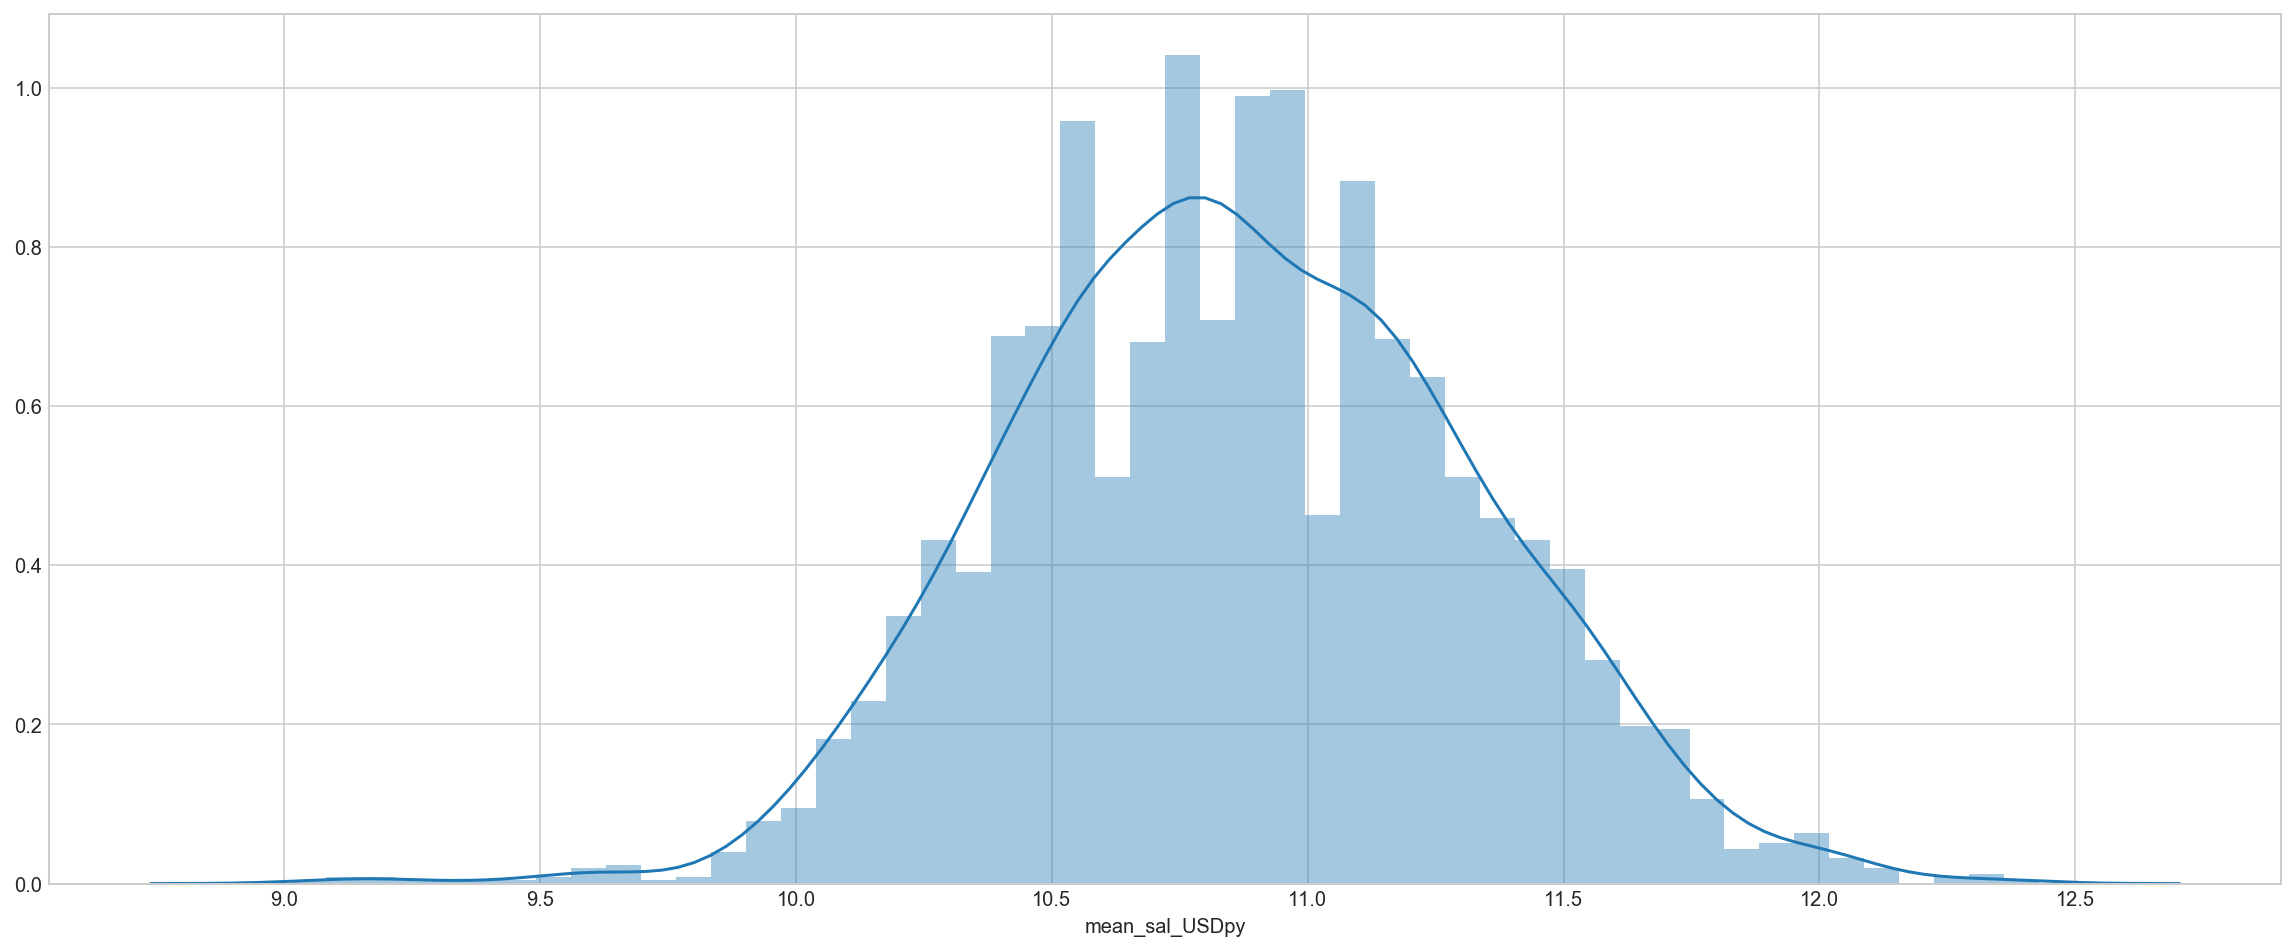

In [24]:
Lg=np.log(df["mean_sal_USDpy"])
fig = plt.subplots(figsize=(20,8))
sns.distplot(Lg, bins=50,)

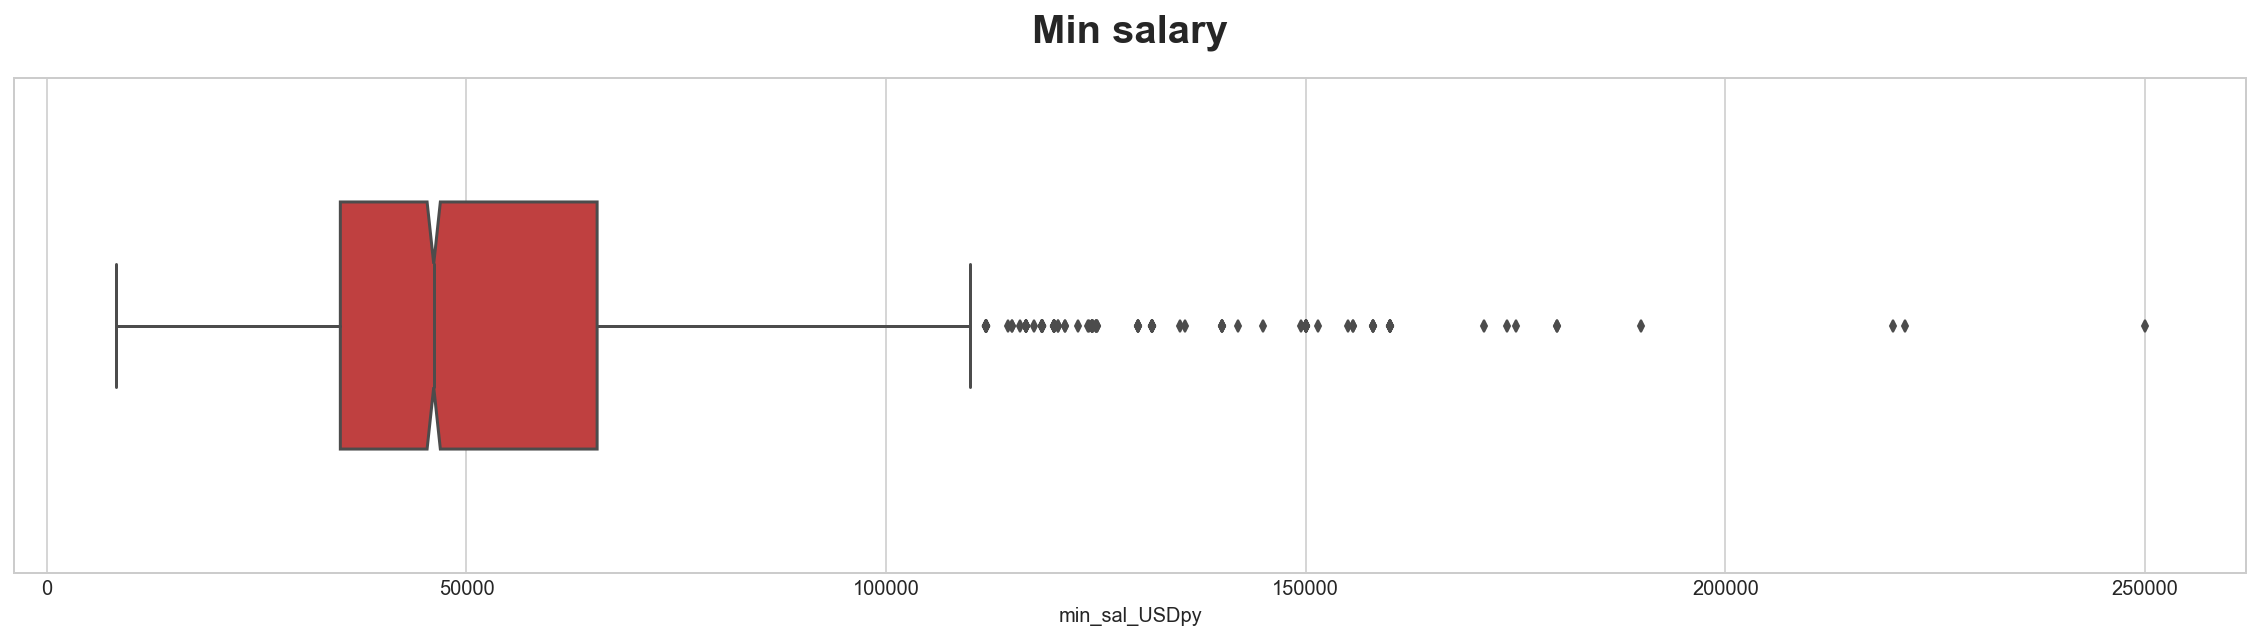

In [25]:
# Minimum Salary

ns.set_style("whitegrid")
plt.figure(figsize = (20,10))

# Min Salary
plt.subplot (2,1,2)
sns.boxplot(df['min_sal_USDpy'], color='red',width=.5,saturation=.5,notch=True,dodge=True, fliersize=4)
plt.title("Min salary", fontsize=20, fontweight='bold', y=1.05,)
#plt.xscale('log')

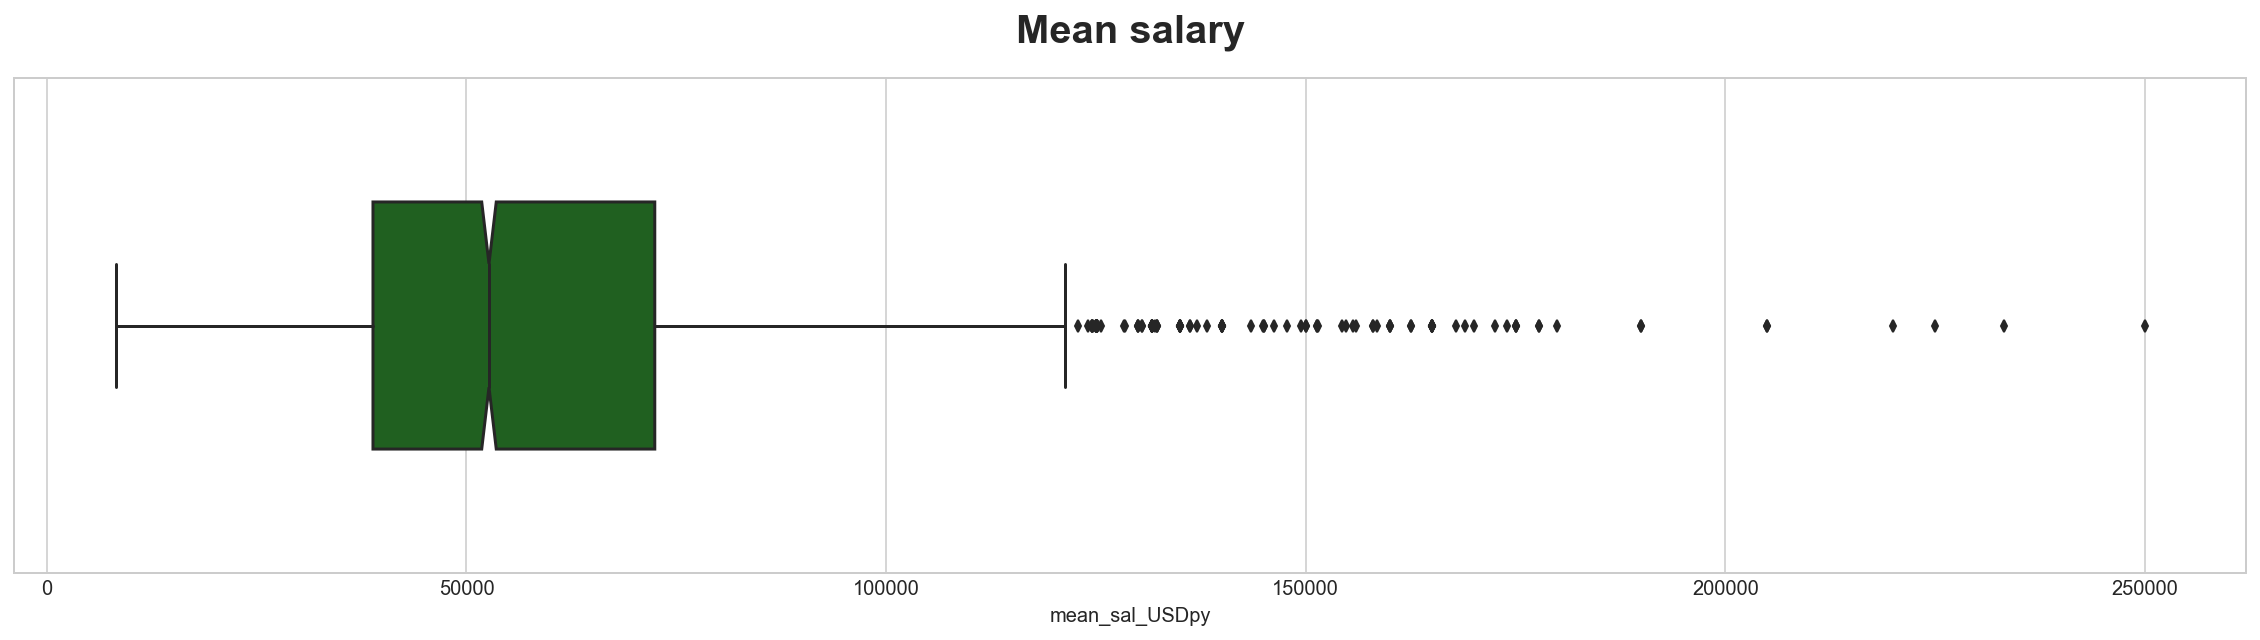

In [27]:
# Mean Salary

sns.set_style("whitegrid")
plt.figure(figsize = (20,10))

# Mean Salary
plt.subplot (2,1,2)
sns.boxplot(df['mean_sal_USDpy'], color='green',width=.5,saturation=.5,notch=True,dodge=True, fliersize=4)
plt.title("Mean salary", fontsize=20, fontweight='bold', y=1.05,)
#plt.xscale('log')

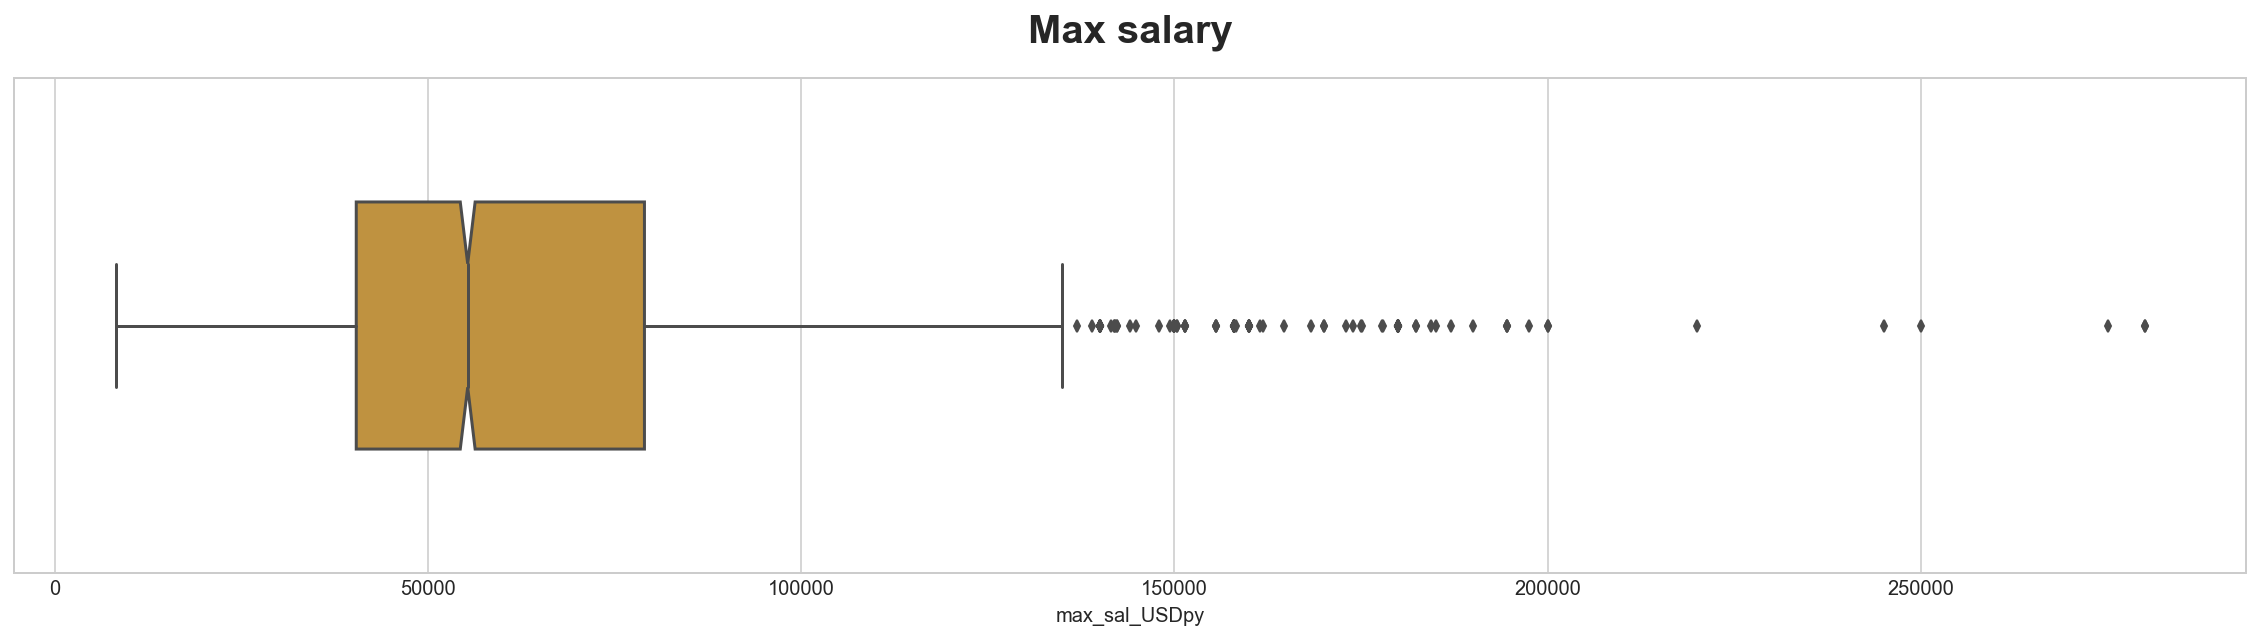

In [28]:
# Maximum Salary

sns.set_style("whitegrid")
plt.figure(figsize = (20,10))

# Max Salary
plt.subplot (2,1,2)
sns.boxplot(df['max_sal_USDpy'], color='orange',width=.5,saturation=.5,notch=True,dodge=True, fliersize=4)
plt.title("Max salary", fontsize=20, fontweight='bold', y=1.05,)
#plt.xscale('log')

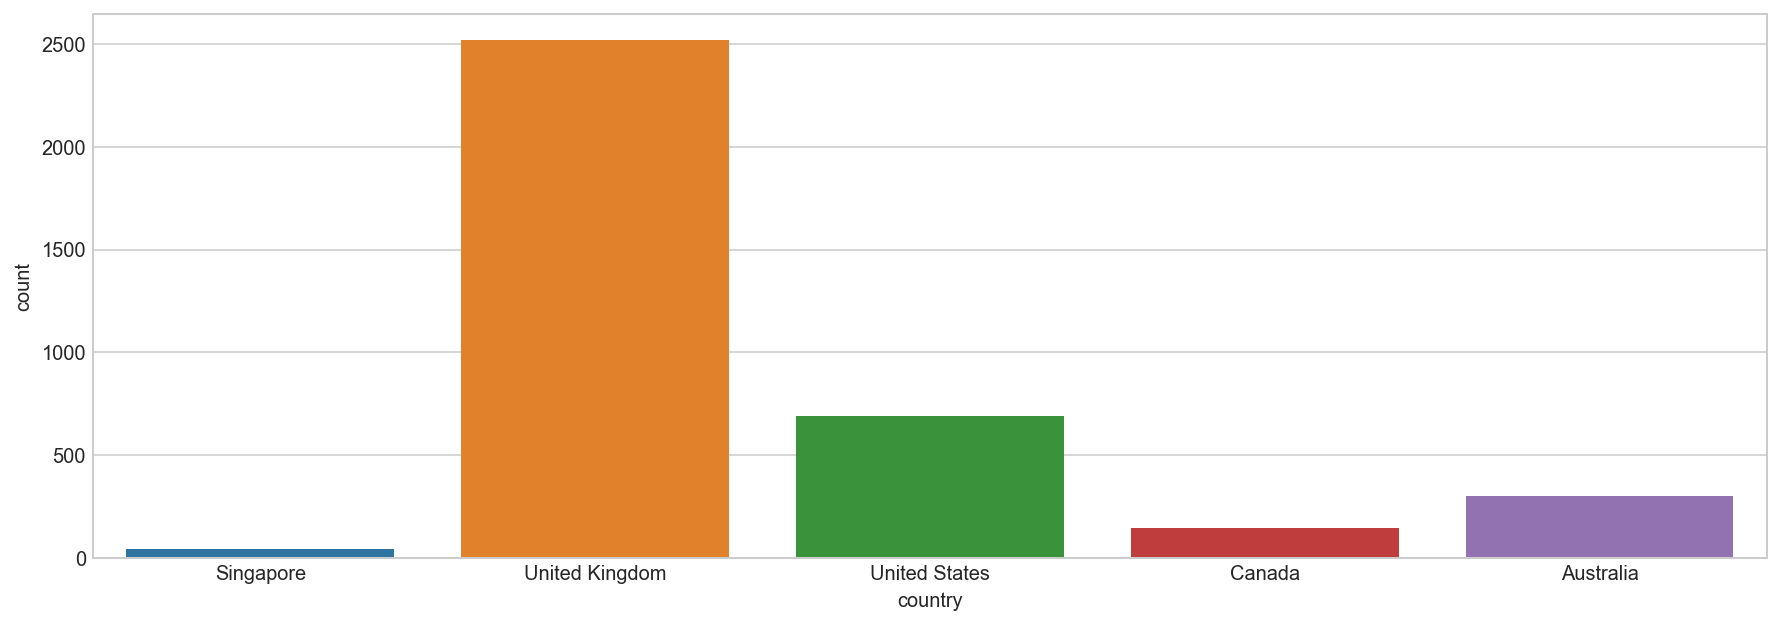

In [29]:
# jobs opening by country

fig = plt.subplots(figsize=(15,5))
sns.countplot(x="country",data=df,)

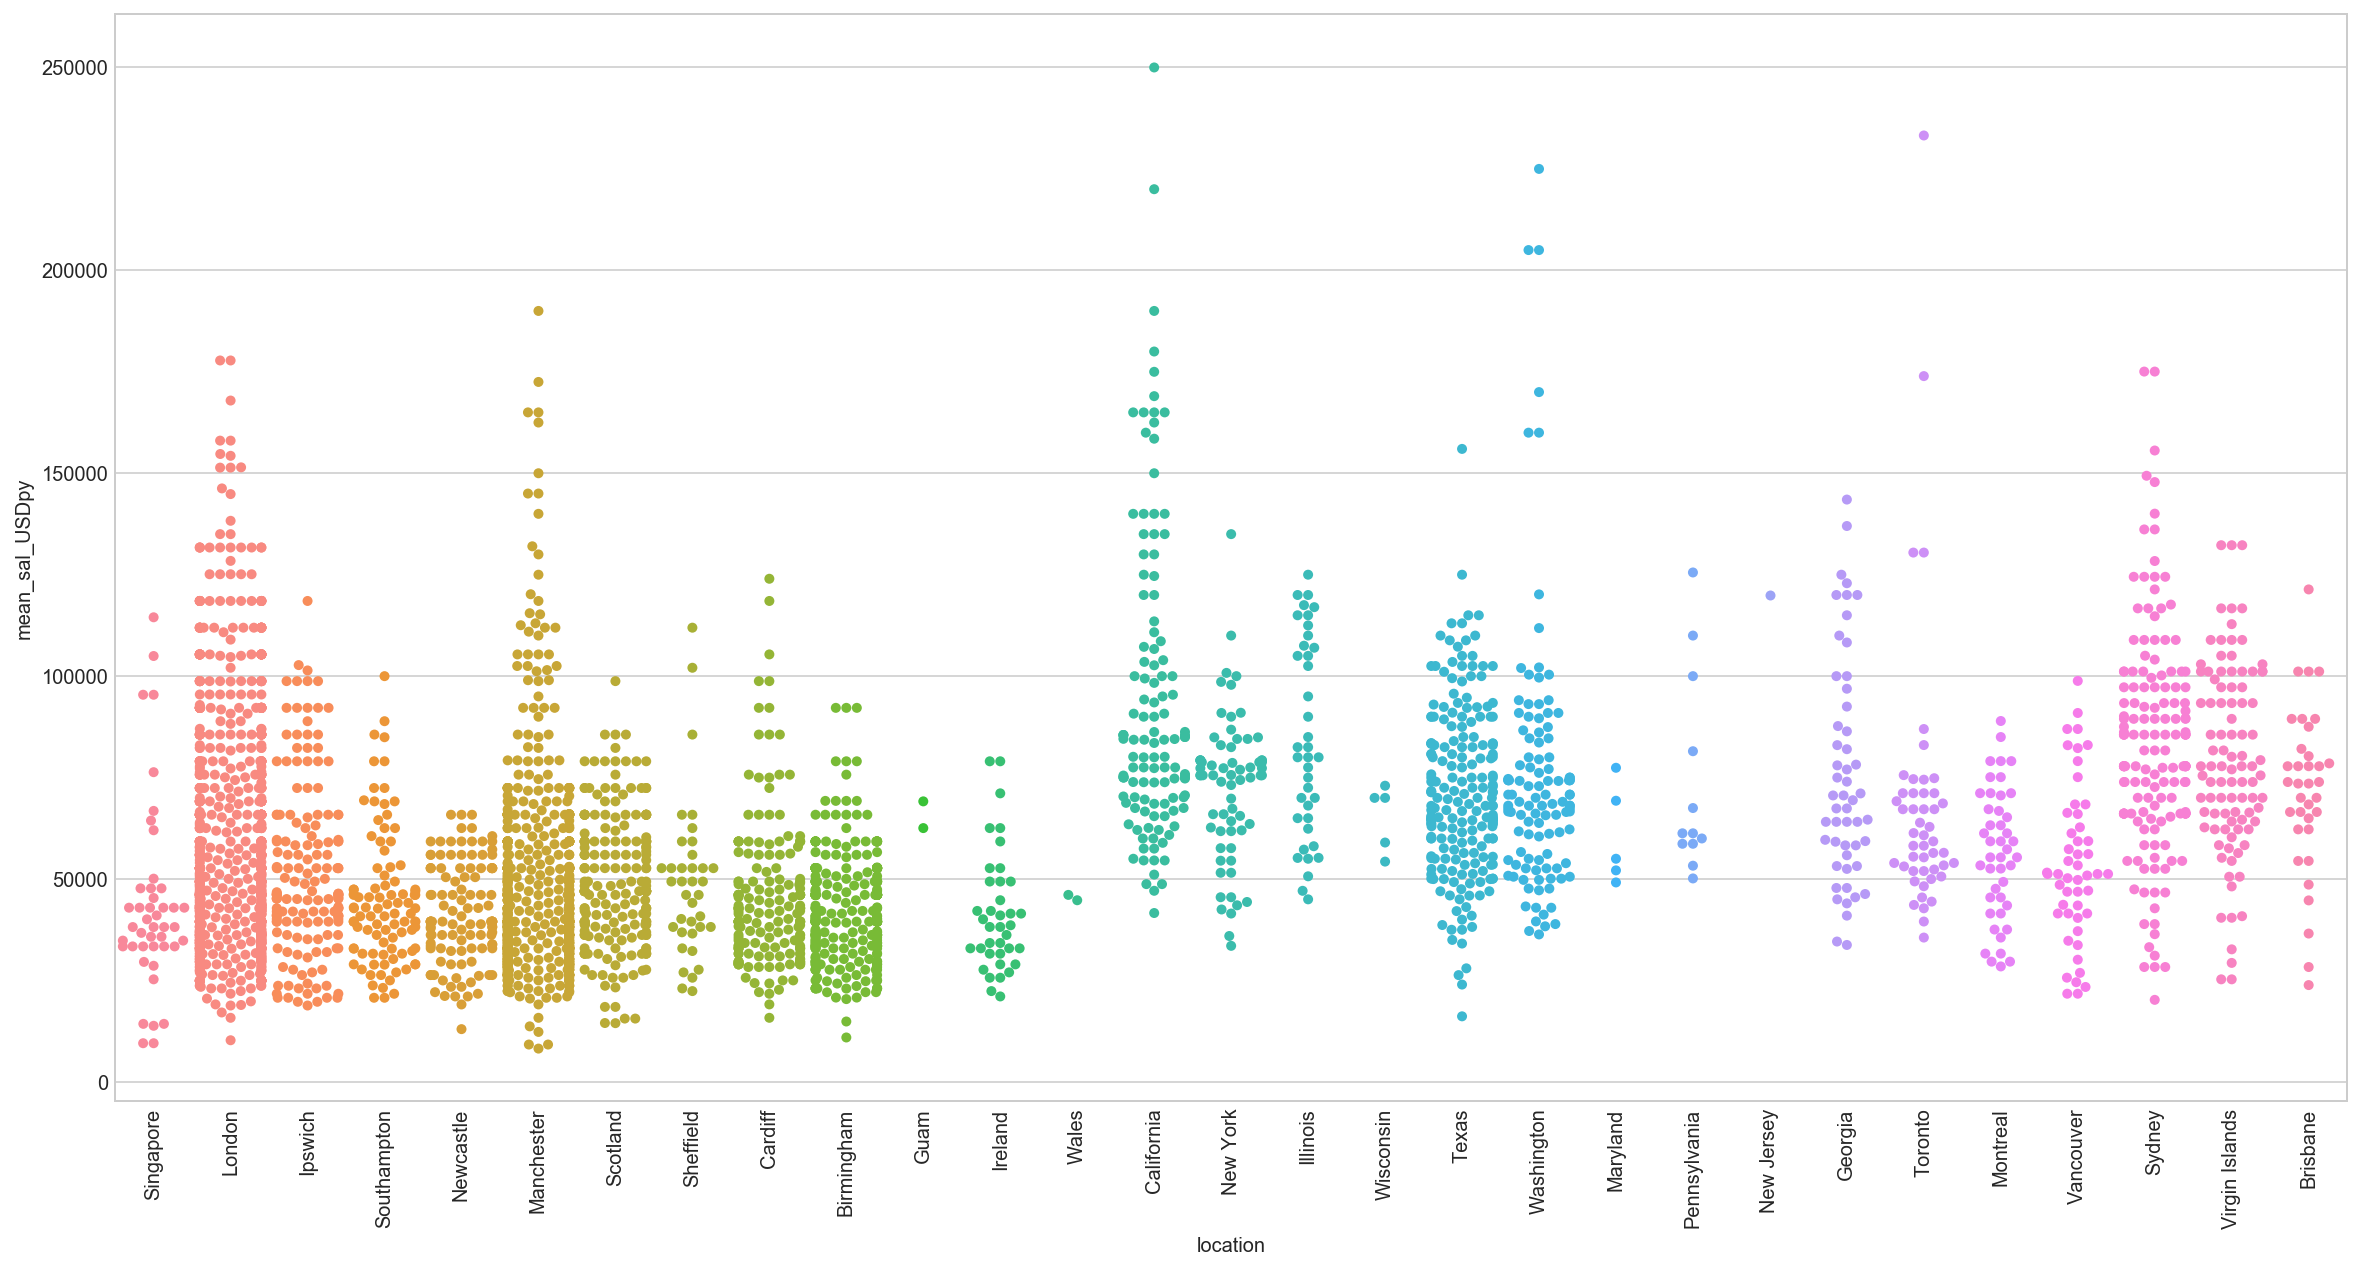

In [75]:
# Salary distribution at different city

plt.subplots(figsize = (20,10))
sns.swarmplot(x =df["location"], y=df["mean_sal_USDpy"], data = df)#.set_xticklabels(70)
plt.xticks(rotation = 90)
plt.show()

#### Consoildation of location to major cities

In [32]:
#Consolidating the locations into major cities

df.loc[df.country.str.contains('United Kingdom'),'location'] = \
df[df.country.str.contains('United Kingdom')].location.astype(str)

sg = ['Tanjong Pagar', 'Pasir Panjang', 'Ang Mo Kio','Central Business District', 'Kallang', 'Jurong East', 'Tuas',
       'Serangoon']

lon = ['Kensington','Merton','Berkshire','Woking','Westerham','Shoreditch','London','Basingstoke','South East','College',
       'Milton Keynes','Cobham','Reading','Surrey','Feltham','Guildford','Kingston upon Thames','Guam',
      'Weybridge','Slough','Bracknell','Leatherhead','Luton','Uxbridge','Farnborough','Maidenhead',
      'Middlesex','Isleworth','Feltham TW13','High Wycombe','Aylesbury HP22','Teddington','New Haw','Camden',
      'West End','Brentford','Hammersmith','South Mimms','Hertford','Hill','Farnham','Staines-upon-Thames','Barnet',
      'County','Welwyn Garden City','Marlow','Redhill','Kent','Hatfield','Uckfield','Essex','Stevenage',"Liverpool Street Station","Barbican","East Anglia","Hitchin","Market","Watford","Harlow","Thames Valley",
       "Basingstoke","St Albans","Margate","Bisham","Canterbury","Chelmsford","Hemel Hempstead",
       "Ashford","Stratfield Mortimer","Croydon","Sutton","Brighton and Hove","Grays","Haywards Heath","Letchworth",
      'Oxford','Newport Pagnell','Didcot','Haddenham','Ardley',"Henley on Thames","Abingdon","Chipping Campden",
       "Kidlington",'Thame','Warwick',"Witney","Buckinghamshire","Wallingford","Leamington Spa","Cheltenham","Farringdon"]

sth = ['Southampton','Fareham','Horsham','Portsmouth','Salisbury','West Sussex','Salisbury','Havant','Bournemouth',
      'Chichester','Newbury','Winchester',"Chandler's Ford",'Eastleigh','Brighton',"Plymouth","Dorchester","Torquay",
       "Hove","Saint Ives","Porton Down",'Kingston upon Hull','Wimborne']

new = ['Newcastle upon Tyne','Yorkshire','Teesside','Sunderland','Gateshead','Durham','Stockton-on-Tees','Stockton-on-Tees TS18'
       'Houghton le Spring','Cramlington','Sedgefield','Peterlee','Middlesbrough','Newton Aycliffe','Cumbria',
      'Tyne and Wear','Birtley','Nebraska','Penrith',"Sand Hutton","Full Sutton",'Washington'] 

manc =['Lancashire','Ripon','Bradford','Brighouse','Halifax','Pudsey','Colne','Harrogate','Leyland','Ilkley',
       'Huddersfield','Barnoldswick','Baildon','Burnley','Bury','High Bentham','Blackburn','Manchester M60',
      'Warrington','Liverpool','Trafford','Bolton','Cheshire','Manchester','Chorley','Wilmslow','Cheadle',
      'Stockport','Salford','Jodrell Bank','Lancaster','Skipton','Handforth','Macclesfield','Wilmslow','Accrington',
      "Telford","Crewe","Bangor","Chirk",'Leeds','York','North East','Boston Spa','Shipley','East Riding of Yorkshire','Wakefield',
      'Pontefract','City of Kingston upon Hull','Humberside','Barnsley','Willerby','Brough HU15','Howden',
      'Newcastle-under-Lyme','Doncaster','Hampshire','Beverley','Mansfield','Doncaster','Lincoln','Scunthorpe',
      'Gainsborough','Castleford','Keighley','Barrow-In-Furness','Preston','Blackpool','Fleetwood','Runcorn','Chester',
       'Golborne','Flintshire','Wirral','Bethesda','Oswestry',"Birkenhead","Knowsley","Bootle",'North West']

scot =['Glasgow','Fife','Dundee','Tranent','Balerno','Dunbartonshire','Stirling','North Lanarkshire','Montrose',
      'Larbert','Montrose','St. Andrews','Edinburgh' ,'Aberdeen','Grampian Region',"Inverness",'Dunfermline']

birm =['Nottingham','Northampton','Leicester','Glamorgan','Solihull','Sutton Coldfield B75',
      'Atherstone','Derby','Birmingham','Walsall','East Midlands','Burton-On-Trent','Coventry','Stoke-on-Trent',
      'Kingswinford','Worcester','Stafford','Wolverhampton','Loughborough','Walsall','Ludlow','Cannock','Kidderminster',
      'Stratford-upon-Avon','Oldbury','Hindlip','Cirencester','Worcestershire',"Waltham on the Wolds","Tamworth",
       "Chesterfield",'Redditch',"Kettering","Stoneleigh","Bromsgrove"]

ire = ['Belfast',"Newry","Coleraine","Douglas","Strabane","Cookstown","Antrim"]

ips = ['Norwich','Eye','Cambridge','Bedford','Colchester','Peterborough','Hinxton','Saffron Walden','Spalding','Ely',
       'Milton','Lowestoft','Suffolk','Huntingdon',"Royston","Harston","Thetford","Wellingborough","Sharnbrook",
       "Rushden","Kedleston","Shrewsbury"] 

card =['West Midlands','Swindon','Swansea','Cardiff','North Tawton','Cwmbran','Somerset','Bath','Newport',
       'Chippenham','Bridgend','Stoke Gifford','Port Talbot','Warminster','Glascoed','Stonehouse','Bridgwater',
       'Plymouth','Westerleigh',"Bristol","Gloucester","Devizes","Poole","Wiltshire","South West","Wales"
        "Wimborne","Abergavenny","Exeter"]

canada = {'QC':'Montreal', 'ON':'Toronto', 'BC':'Vancouver'}
aus = {'VIC':'Melbourne', 'NSW':'Sydney', 'QLD':'Brisbane','WA':'Perth'}
us = {"AL": "Alabama","AK": "Alaska","AS": "American Samoa","AZ": "Arizona","AR": "Arkansas","CA": "California",
"CO": "Colorado","CT": "Connecticut","DE": "Delaware","DC": "District Of Columbia","FM": "Federated States Of Micronesia",
"FL": "Florida","GA": "Georgia","GU": "Guam","HI": "Hawaii","ID": "Idaho","IL": "Illinois","IN": "Indiana","IA": "Iowa",
"KS": "Kansas","KY": "Kentucky","LA": "Louisiana","ME": "Maine","MH": "Marshall Islands","MD": "Maryland","MA": "Massachusetts",
"MI": "Michigan","MN": "Minnesota","MS": "Mississippi","MO": "Missouri","MT": "Montana","NE": "Nebraska","NV": "Nevada",
"NH": "New Hampshire","NJ": "New Jersey","NM": "New Mexico","NY": "New York","NC": "North Carolina","ND": "North Dakota",
"MP": "Northern Mariana Islands","OH": "Ohio","OK": "Oklahoma","OR": "Oregon","PW": "Palau","PA": "Pennsylvania",
"PR": "Puerto Rico","RI": "Rhode Island","SC": "South Carolina","SD": "South Dakota","TN": "Tennessee","TX": "Texas",
"UT": "Utah","VT": "Vermont","VI": "Virgin Islands","VA": "Virginia","WA": "Washington","WV": "West Virginia",
"WI": "Wisconsin","WY": "Wyoming"}

In [33]:
# United Kingdom

for key in lon:
    df.loc[df.location.str.contains(key),'location'] = 'London'
           
for key in sth:
    df.loc[df.location.str.contains(key),'location'] = 'Southampton'
           
for key in new:   
    df.loc[df.location.str.contains(key),'location'] = 'Newcastle'
           
for key in manc:   
    df.loc[df.location.str.contains(key),'location'] = 'Manchester'
           
for key in scot: 
    df.loc[df.location.str.contains(key),'location'] = 'Scotland'
            
for key in birm:   
    df.loc[df.location.str.contains(key),'location'] = 'Birmingham'
           
for key in ire:   
    df.loc[df.location.str.contains(key),'location'] = 'Ireland'
            
for key in ips:    
    df.loc[df.location.str.contains(key),'location'] = 'Ipswich'
            
for key in card:    
    df.loc[df.location.str.contains(key),'location'] = 'Cardiff'

df.drop(df[df.location.str.contains('Stockton-On-Tees TS18')].index, axis=0, inplace = True)
df.loc[df.location.str.contains("Remote"),"location"]="California"
df.loc[df.location.str.contains("Houghton le Spring"),"location"]="Newcastle"
df.loc[df.location.str.contains("Guam"),"location"]="London"

# United States

for key in us.keys():
    
        df.loc[df.location.str.contains(key),'location'] = us[key]
    
# Canada
    
for key in canada.keys():
    
        df.loc[df.location.str.contains(key),'location'] = canada[key]
    
# Austrialia

for key in aus.keys():
        df.loc[df.location.str.contains(key),'location'] = aus[key]
    
# Singapore      
for key in sg:   
        df.loc[df.location.str.contains(key),'location'] = 'Singapore' 
       
        
df.location=df.location.astype(str)

In [34]:
df.location.unique()

array(['Singapore', 'London', 'Ipswich', 'Southampton', 'Newcastle',
       'Manchester', 'Scotland', 'Sheffield', 'Cardiff', 'Birmingham',
       'Guam', 'Ireland', 'Wales', 'California', 'New York', 'Illinois',
       'Wisconsin', 'Texas', 'Washington', 'Maryland', 'Pennsylvania',
       'New Jersey', 'Georgia', 'Toronto', 'Montreal', 'Vancouver',
       'Sydney', 'Virgin Islands', 'Brisbane'], dtype=object)

#### Changing  title to lower spelling and seperating to analyst and scientist

In [37]:
df.loc[:,"title"] = df.title.str.lower()

In [38]:
analyst = df[df.title.str.contains("analyst")]
analyst.shape

(2168, 14)

In [39]:
sci = df[df.title.str.contains("scientist")]
sci.shape

(584, 14)

#### Concat 2 DF (analyst and Scientist)

In [40]:
Ana_Sci = pd.concat([analyst,sci],axis=0)
Ana_Sci.shape

(2752, 14)

In [43]:
Ana_Sci.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752 entries, 9 to 3655
Data columns (total 14 columns):
level_0           2752 non-null int64
index             2752 non-null int64
company           2745 non-null object
country           2752 non-null object
description       2752 non-null object
location          2752 non-null object
review            1229 non-null object
salary            2752 non-null object
star              1229 non-null object
title             2752 non-null object
multiplier        2752 non-null int64
min_sal_USDpy     2752 non-null float64
max_sal_USDpy     2752 non-null float64
mean_sal_USDpy    2752 non-null float64
dtypes: float64(3), int64(3), object(8)
memory usage: 322.5+ KB


#### Using Linear Regression Model

In [45]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [46]:
# STEP 1 Identifying & Setting up the X and y variables
y = np.log(Ana_Sci["mean_sal_USDpy"])
X = Ana_Sci.title.values

In [47]:
# STEP 2 Setting up train and test set ( 70/30 split and randomize)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [48]:
# STEP 3 Vectorize of data prior to fitting process (By job title)
Vect = TfidfVectorizer(max_df=0.7,max_features=5000, ngram_range = (1,5), stop_words="english")
tran1 = Vect.fit_transform(X_train)
tran2 = Vect.transform(X_test)

In [49]:
print tran1.shape
print tran2.shape

(1926, 5000)
(826, 5000)


In [50]:
# STEP 4  Regression Model fit
lm = LinearRegression()
lm.fit(tran1, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [51]:
print "The y _intercept : ",(lm.intercept_)

The y _intercept :  10.8638377775


In [52]:
prediction=lm.predict(tran2)

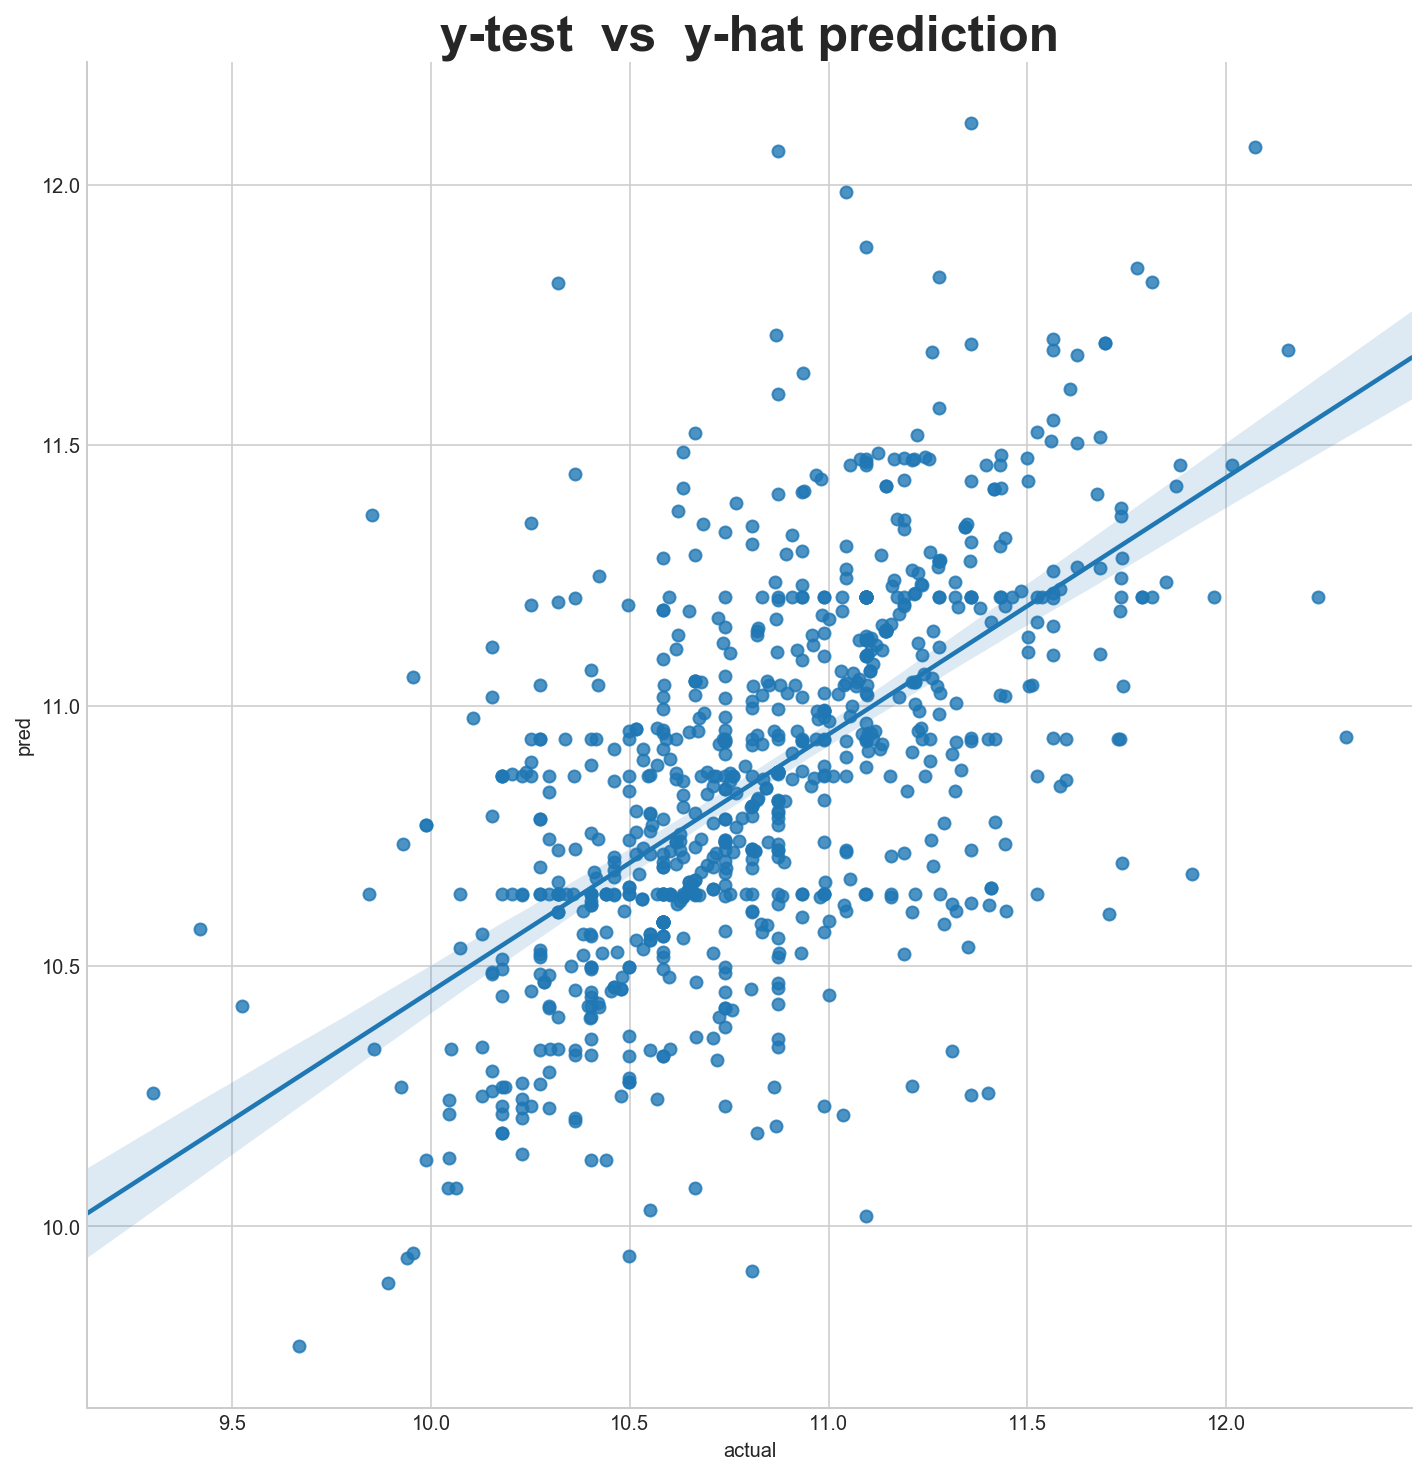

In [53]:
dfpred= pd.DataFrame(data = zip(y_test,prediction),columns=['actual', 'pred'])
sns.lmplot(x='actual',y='pred',data=dfpred,size=10)
plt.title("y-test  vs  y-hat prediction", fontsize=25, fontweight='bold')

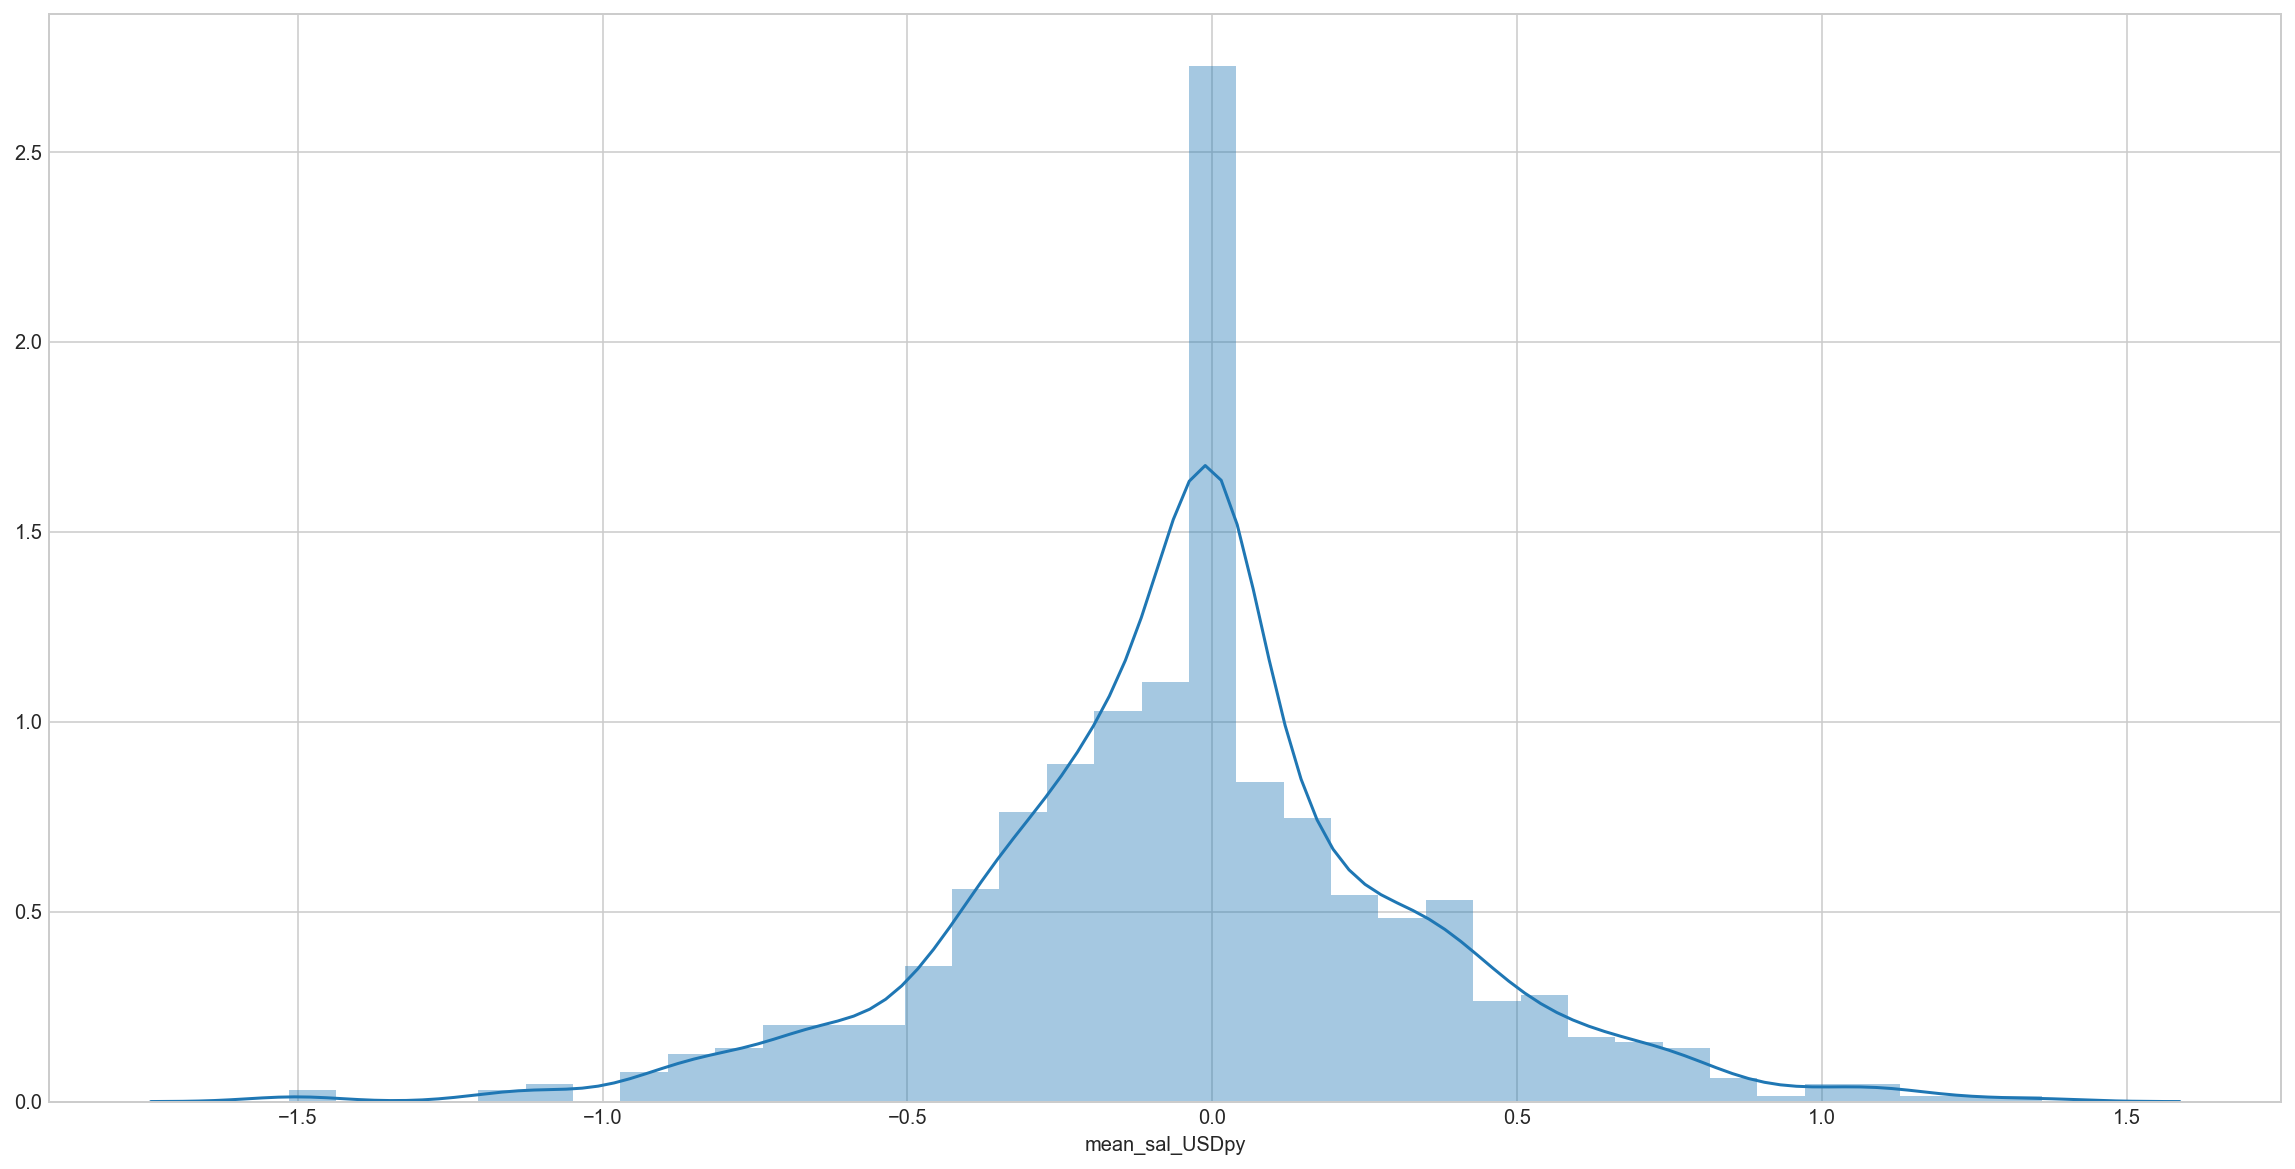

In [54]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot((y_test-prediction))

In [55]:
# STEP 7 _ LINEAR REGRESSION METRICS....

# Calculate and print metrics
print"Mean Abs Error :", metrics.mean_absolute_error(y_test,prediction)
print"Mean Sqr_Error :" ,metrics.mean_squared_error(y_test,prediction)
print"Mean_Root Sqr Error:",np.sqrt(metrics.mean_squared_error(y_test,prediction))

# Calculate and print score
print "Linear Regression Score :", lm.score(tran2,y_test)
# Calculate mean of 
print "Y_hat_Mean(lr) :" ,np.mean(prediction)


Mean Abs Error : 0.261818248992
Mean Sqr_Error : 0.13515875243
Mean_Root Sqr Error: 0.367639432637
Linear Regression Score : 0.28319135766
Y_hat_Mean(lr) : 10.8632115086


#### Ridge and Lasso

In [56]:
# Running RIDGE Model

Rig1=Ridge(alpha=0.001)
Rig1.fit(tran1, y_train)

Pred3=Rig1.predict(tran2)
print "RIDGE Score :",Rig1.score(tran2,y_test)


RIDGE Score : 0.312991836612


In [57]:
# Running LASSO Model 

las1=Lasso(alpha=0.001)
las1.fit(tran1,y_train)

Pred2=las1.predict(tran2)
print "LASSO Score :",las1.score(tran2,y_test)


LASSO Score : 0.238742106892


#### Decision Tree

In [58]:
# STEP 1 Identifying & Setting up the X and y variables
y = np.log(Ana_Sci["mean_sal_USDpy"])
X = Ana_Sci.title.values

In [59]:
# STEP 2 Setting up train and test set ( 70/30 split and randomize)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [60]:
# STEP 3 Vectorize of data prior to fitting process (By job title)
Vect = TfidfVectorizer(max_df=0.7,max_features=5000, ngram_range = (1,5), stop_words="english")
tran1 = Vect.fit_transform(X_train)
tran2 = Vect.transform(X_test)

In [61]:
# STEP 4  Decision tree Model fit
dmr = DecisionTreeRegressor(criterion="mse", splitter="best", max_depth=10)
dmr.fit(tran1, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
prediction=lm.predict(tran2)

#### Feature_importance Selection (top 10)

In [64]:
Select = pd.DataFrame(data=zip (Vect.get_feature_names(),dmr.tree_.compute_feature_importances()),
             columns=["Features","Importance"]).sort_values("Importance",ascending=False)

In [66]:
 Select.head(10).transpose()

,1023,1282,3635,957,4511,778,1468,2676,3423,1600
Features,data scientist,graduate,senior,data analyst,systems,business,junior,quantitative,scientist intern,machine learning
Importance,0.354899,0.0863958,0.0762598,0.0467354,0.0449536,0.0431704,0.0321746,0.0273591,0.0221045,0.0202379


In [67]:
Select.tail(10).transpose()

,1690,1689,1688,1687,1686,1685,1684,1683,1682,4999
Features,market analyst japanese speaking researcher,market analyst japanese speaking,market analyst japanese,market analyst,market,margin analyst,margin,manufacturing brand,manufacturing,yorkshire insurance 42k
Importance,0,0,0,0,0,0,0,0,0,0


#### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [68]:
Ana_Sci

,level_0,index,company,country,description,location,review,salary,star,title,multiplier,min_sal_USDpy,max_sal_USDpy,mean_sal_USDpy
9,9,10,TSA Solutions,Singapore,Knowledge of SQL for retrieving data. Support ...,Singapore,None,3000 - 4300,None,data analyst,13,28625.954198,41030.534351,34828.244275
10,10,4,BGC Group Pte Ltd,Singapore,Assist in basic data entry and other administr...,Singapore,3,1300 - 1600,40.8,data analyst (1.6/mth) - xy,13,12404.580153,15267.175573,13835.877863
11,11,4,Beacon Consulting,Singapore,Data cleaning (e.g. Update fieldwork on data i...,Singapore,None,3000 - 6000,None,research analyst (data analytics),13,28625.954198,57251.908397,42938.931298
12,12,9,Raintree Partnership,Singapore,Financial Markets Analyst. Analyze data points...,Singapore,None,6000 - 7500,None,financial markets analyst,13,57251.908397,71564.885496,64408.396947
13,13,6,Beacon Consulting,Singapore,Data cleaning (e.g. Update fieldwork on data i...,Singapore,None,3000 - 6000,None,research analyst (full-time),13,28625.954198,57251.908397,42938.931298
14,14,9,Collabera,Singapore,Installing/de-installing/relocating all Data C...,Singapore,479,4300,42.6,data center infrastructure analyst,13,41030.534351,41030.534351,41030.534351
15,15,7,TSA Solutions,Singapore,Knowledge of SQL for retrieving data. Support ...,Singapore,None,3000 - 4000,None,business analyst,13,28625.954198,38167.938931,33396.946565
16,16,4,Prime Solutions Provider Pte Ltd,Singapore,Analyse financial data by monitoring market tr...,Singapore,None,3500,None,junior financial analyst,13,33396.946565,33396.946565,33396.946565
18,18,3,TSA Solutions,Singapore,Knowledge of SQL for retrieving data. Support ...,Singapore,None,3000 - 4000,None,revenue performance analyst,13,28625.954198,38167.938931,33396.946565
19,19,9,Thermo Fisher Scientific,Singapore,Experience using advanced analytical tools (SQ...,Singapore,1441,3800 - 4200,42.6,transport analyst - costing and logistic(sql),13,36259.541985,40076.335878,38167.938931


In [78]:
# Creating new columns and features
Ana_Sci["pos"]= 0

In [82]:
Ana_Sci.loc[Ana_Sci.title.str.contains("data scientist"),"pos"]=1

In [104]:
def Classification (data,Target):
    
    from sklearn.linear_model import LogisticRegressionCV
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.model_selection import train_test_split

    # Train , test , Split
    X = data
    y = Target
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=101,shuffle=True)
    
    Vect = TfidfVectorizer(max_df=0.7,max_features=5000, ngram_range = (1,5), stop_words="english")
    tran1 = Vect.fit_transform(X_train)
    tran2 = Vect.transform(X_test)
    
    #classification model
    sm = LogisticRegressionCV(Cs=50, cv=5, penalty="l2", scoring=None, solver="lbfgs",class_weight={1:0.8, 0:0.2}, n_jobs=3, verbose=1)
    sm.fit(tran1, y_train)
    yhat = sm.predict(tran2)
    #yhat_pp = sm.predict_proba(tran2)
    
    #output result
    conmat = np.array(confusion_matrix(y_test, yhat, labels=[1,0]))
    print conmat
    
    conrep = classification_report(y_test, yhat,)
    print conrep
    


In [105]:
Classification(Ana_Sci["description"],Ana_Sci["pos"])

[[ 92  22]
 [ 10 702]]
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       712
          1       0.90      0.81      0.85       114

avg / total       0.96      0.96      0.96       826



[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.9s finished


In [106]:
Ana_Sci.company =Ana_Sci.company.astype("unicode")
Ana_Sci.company =Ana_Sci.company.str.lower()

In [107]:
Classification(Ana_Sci["company"],Ana_Sci["pos"])

/anaconda/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/anaconda/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


[[ 33  81]
 [ 31 681]]
             precision    recall  f1-score   support

          0       0.89      0.96      0.92       712
          1       0.52      0.29      0.37       114

avg / total       0.84      0.86      0.85       826



[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.1s finished
